In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from collections import Counter

from tensorflow import keras
from tensorflow.keras import models, layers

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

#from tensorflow.keras.utils import image_dataset_from_directory

# from tensorflow.keras.applications.xception import Xception
# from tensorflow.keras.applications.xception import preprocess_input
# from tensorflow.keras.applications.xception import decode_predictions

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.inception_v3 import decode_predictions

2022-12-20 14:51:59.467698: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
def render_history(history):
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.title("Our losses")
    plt.show()
    plt.close()

    plt.plot(history["accuracy"], label="accuracy")
    plt.plot(history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.title("Our accuracies")
    plt.show()
    plt.close()
    

def model_pretrained_arch1():
# def model_pretrained_arch1(learning_rate):
    
    model = models.Sequential()

    model.add(layers.InputLayer(input_shape=(250, 250, 3)))
    
    model.add(layers.Rescaling(1./127.5, offset=-1))
    model.add(layers.RandomFlip("horizontal_and_vertical"))
    model.add(layers.RandomRotation(0.2))

    model.add(pre_trained_model)

    model.add(layers.Conv2D(32, (3, 3), padding='same'))
    # model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # model.add(layers.Conv2D(32, (3, 3), padding='same'))
    # model.add(layers.BatchNormalization())
    # model.add(layers.Activation('relu'))
    # model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.5))
    # model.add(layers.Dense(16, activation='relu'))
    # model.add(layers.Dropout(0.5))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  
    
    opt = tf.keras.optimizers.SGD()
    # opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.8)
    # opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    # opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [3]:
image_size = (250, 250)
batch_size = 32
epochs = 300

In [4]:
train_ds = image_dataset_from_directory(
    '../dat/train/', 
    seed=4231,
    image_size=image_size, 
    shuffle=True,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)

val_ds = image_dataset_from_directory(
    '../dat/val/', 
    seed=4231,
    image_size=image_size, 
    shuffle=True,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)

test_ds = image_dataset_from_directory(
    '../dat/test/', 
    seed=4231,
    image_size=image_size, 
    shuffle=False,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)

Found 2816 files belonging to 2 classes.


2022-12-20 14:52:01.329208: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 14:52:01.427418: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 14:52:01.428089: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 14:52:01.432621: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Found 412 files belonging to 2 classes.
Found 764 files belonging to 2 classes.


In [5]:
class_names = train_ds.class_names
print(class_names)

['female', 'male']


In [6]:
pre_trained_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(250, 250, 3)
)

# freeze convolutional layers and don't include dense layers
pre_trained_model.trainable = False
# pre_trained_model.summary()

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


# train_aug_ds = train_aug_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_aug_ds = val_aug_ds.cache().prefetch(buffer_size=AUTOTUNE)

# train_aug_gray_ds = train_aug_gray_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_aug__gray_ds = val_aug_gray_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
lr_sched = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-2 * (0.80 ** np.floor(epoch / 2)))

In [9]:
model = model_pretrained_arch1()

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 250, 250, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 250, 250, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 250, 250, 3)      0         
 tion)                                                           
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 conv2d_94 (Conv2D)          (None, 6, 6, 32)          589856    
                                                                 
 activation_94 (Activation)  (None, 6, 6, 32)          0         
                                                        

In [11]:
history_list = {}

In [12]:
history = model.fit(
    train_ds,
    batch_size=20,
    epochs=epochs,
    validation_data=val_ds, 
    callbacks=[lr_sched]
)

history_list['model_1'] = history.history

Epoch 1/300


2022-12-20 14:52:13.631597: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-12-20 14:52:15.913622: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-20 14:52:15.914812: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-20 14:52:15.914853: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-20 14:52:15.915785: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-20 14:52:15.915874: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


88/88 [==============================] - 44s 348ms/step - loss: 0.7105 - accuracy: 0.5273 - val_loss: 0.6856 - val_accuracy: 0.5631 - lr: 0.0100
Epoch 2/300
88/88 [==============================] - 9s 101ms/step - loss: 0.6955 - accuracy: 0.5146 - val_loss: 0.6886 - val_accuracy: 0.5583 - lr: 0.0100
Epoch 3/300
88/88 [==============================] - 9s 102ms/step - loss: 0.6955 - accuracy: 0.5238 - val_loss: 0.6861 - val_accuracy: 0.5680 - lr: 0.0080
Epoch 4/300
88/88 [==============================] - 9s 102ms/step - loss: 0.6897 - accuracy: 0.5391 - val_loss: 0.6820 - val_accuracy: 0.5583 - lr: 0.0080
Epoch 5/300
88/88 [==============================] - 9s 102ms/step - loss: 0.6897 - accuracy: 0.5323 - val_loss: 0.6850 - val_accuracy: 0.5583 - lr: 0.0064
Epoch 6/300
88/88 [==============================] - 9s 102ms/step - loss: 0.6889 - accuracy: 0.5376 - val_loss: 0.6872 - val_accuracy: 0.5583 - lr: 0.0064
Epoch 7/300
88/88 [==============================] - 9s 101ms/step - loss: 

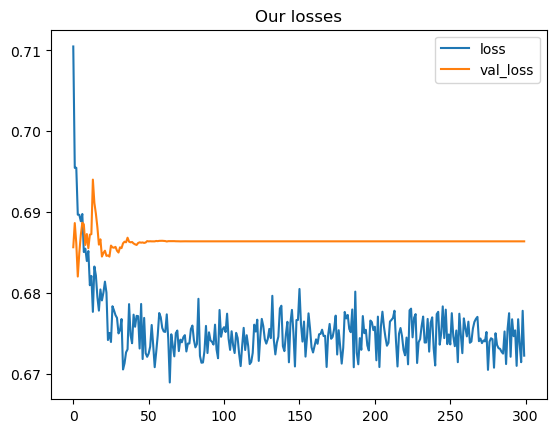

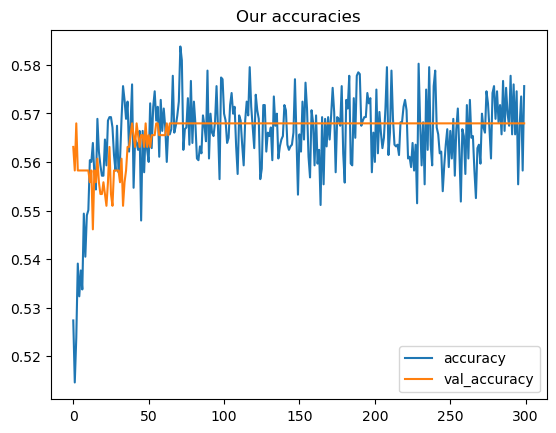

In [13]:
render_history(history.history)